In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from skimage.measure import block_reduce
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#### About our classification problem:

The data consists of Blood cells images that are classified into 4 types:
 - Lymphocyte
 - Monocyte
 - Neutrophil
 - Eosinophil

The operations for image processing:
 - Loading the images at half their original size, 120 * 160 * 3
 - Conversion from BGR to RGB
 - Reducing colors to 9 RGB colors by K-means algorithm
 - Running PCA with a value of 2000 to refine the important pixels in the image
 - Reducing dimensions of images using Max Pool to 24 * 32 * 3

The processed data contains flattened images as vectors.

#### The questions we had before we started working with the data:

1. There are no sharp differences between the different classes and some of the four types of cells are very similar in structure. Can we still classify them properly?
2. Furthermore, won't the use of dimension reduction techniques such as pca or pooling, which are supposed to make training easier, make it difficult to distinguish between the different classes?
3. Can we achieve a good level of accuracy also using the models we learned and without using neural networks? (In neural networks, the learning is done on the shape of the original image, this is in contrast to the models we learned that work according to a vector)

In [5]:
in_dir = 'dataset2-master/dataset2-master/images'

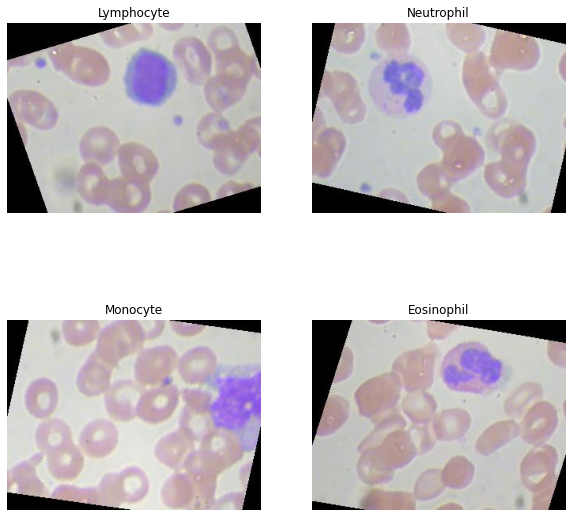

<Figure size 864x576 with 0 Axes>

In [6]:

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
def plotImage(h,w,image_path,title):
    image = cv2.imread(image_path)  # BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # RGB
    axes[w,h].imshow(image)
    axes[w,h].axis('off')
    axes[w,h].set_title(title)
    
plt.figure(figsize=(12,8))
lymp_path = os.path.join(in_dir, 'TRAIN/LYMPHOCYTE') 
mono_path = os.path.join(in_dir, 'TRAIN/MONOCYTE')
neu_path = os.path.join(in_dir, 'TRAIN/NEUTROPHIL')
eos_path = os.path.join(in_dir, 'TRAIN/EOSINOPHIL')
plotImage(0,0,os.path.join(lymp_path, random.choice(os.listdir(lymp_path))),'Lymphocyte')
plotImage(0,1,os.path.join(mono_path, random.choice(os.listdir(mono_path))),'Monocyte')
plotImage(1,0,os.path.join(neu_path, random.choice(os.listdir(neu_path))),'Neutrophil')
plotImage(1,1,os.path.join(eos_path, random.choice(os.listdir(eos_path))),'Eosinophil')
plt.tight_layout()
plt.show()

Total Train samples: 9957

Total Test samples: 2487



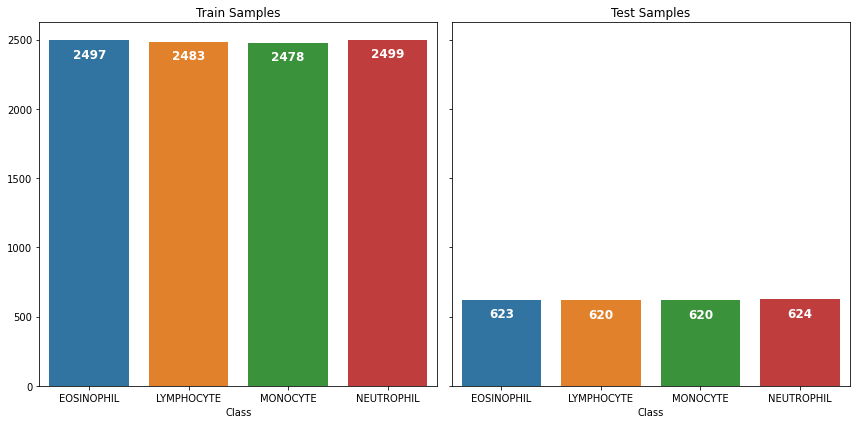

In [7]:
train_dir = os.path.join(in_dir, "TRAIN")
test_dir = os.path.join(in_dir, "TEST")
num_samples = 0
def plot_num_samples(path, s, ax):
    x = []
    y = []
    num_samples = 0
    for cls in os.listdir(path):
        num_imgs = len(os.listdir(os.path.join(path, cls)))
        num_samples += num_imgs
        x.append(cls)
        y.append(num_imgs)

    print('Total ' + s + ' samples: {:d}\n'.format(num_samples))
    sns.barplot(x=x, y=y, ax=ax)
    ax.set_xlabel('Class')
    ax.set_title(s + ' Samples')
    for index, value in enumerate(y):
        ax.text(index, value-150, str(value), ha='center', va='bottom', color='white',weight='bold', fontsize=12)



fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
plot_num_samples(train_dir, "Train", ax1)
plot_num_samples(test_dir, "Test", ax2)
plt.tight_layout()
plt.show()

As you can see, the classes are almost completely equal in size, both in the train and in the test.


In [8]:
def equalize_hist_rgb(image):
    # Split the image into color channels
    b, g, r = cv2.split(image)

    # Apply histogram equalization to each channel
    b_eq = cv2.equalizeHist(b)
    g_eq = cv2.equalizeHist(g)
    r_eq = cv2.equalizeHist(r)

    # Merge the equalized channels back into an RGB image
    equalized_image = cv2.merge([b_eq, g_eq, r_eq])

    return equalized_image

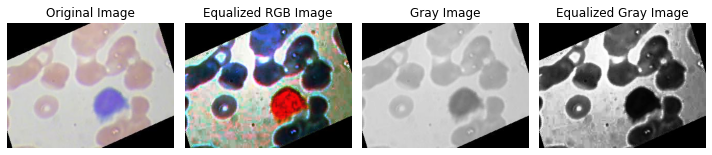

In [9]:
random_file = random.choice(os.listdir(lymp_path))
image = cv2.imread(os.path.join(lymp_path, random_file), cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(os.path.join(lymp_path, random_file))
image2 = image2[:, :, [2, 1, 0]]
image3 = cv2.imread(os.path.join(lymp_path, random_file))



# Perform histogram equalization
equalized_image = cv2.equalizeHist(image)
# Display the original and equalized images
plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)
plt.imshow(image2)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(equalize_hist_rgb(image3))
plt.title('Equalized RGB Image')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(image, cmap='gray')
plt.title('Gray Image')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(equalized_image, cmap='gray')
plt.title('Equalized Gray Image')
plt.axis('off')


plt.tight_layout()
plt.show()

Since we are mainly interested in being able to distinguish the abnormal blood cell and identify its shape, it seems that working on RGB format allows this in the best way (It can be seen that image processing by histogram equalization does not provide better results than normal RGB).

Later in the notebook we check the accuracy of the models with the images in grayscale.

In [10]:
def read_resize_img(path, t='RGB'):
    image = cv2.imread(path)  # BGR
    if t == 'RGB':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    elif t == 'GRAY':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    resized_image = cv2.resize(image, (160, 120))
    return resized_image

In [11]:
def create_sub_df(directory_path,num_cls,t='RGB'):
    if t == 'RGB':
        images = np.ndarray((len(os.listdir(directory_path)),120*160*3), dtype=np.uint8)
    elif t == 'GRAY':
        images = np.ndarray((len(os.listdir(directory_path)),120*160), dtype=np.uint8)
    i=0
    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)
        resized_image = read_resize_img(file_path,t)
        images[i,:] = resized_image.ravel()
        i+=1
    df = pd.DataFrame(images)
    df["target"] = num_cls
    return df

def create_df(directory_path,t='RGB'):
    clss = []
    for cls in os.listdir(directory_path):
        if str(cls) == "MONOCYTE":
            clss.append(create_sub_df(os.path.join(directory_path, cls),1,t))
        elif str(cls) == "LYMPHOCYTE":
            clss.append(create_sub_df(os.path.join(directory_path, cls),2,t))
        elif str(cls) == "NEUTROPHIL":
            clss.append(create_sub_df(os.path.join(directory_path, cls),3,t))
        elif str(cls) == "EOSINOPHIL":
            clss.append(create_sub_df(os.path.join(directory_path, cls),4,t))
    df = pd.concat(clss)
    return shuffle(df).reset_index(drop=True)

In [12]:
df_train = create_df(train_dir)
df_test = create_df(test_dir)

### PCA


PCA can effectively remove noise and irrelevant features from the images, enhancing the signal-to-noise ratio and improving the performance of subsequent machine learning algorithms.

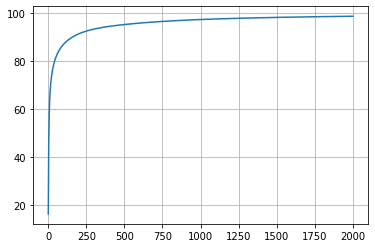

In [24]:
pca = PCA(n_components=2000)
pca.fit(df_train)
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.savefig('pca.png')

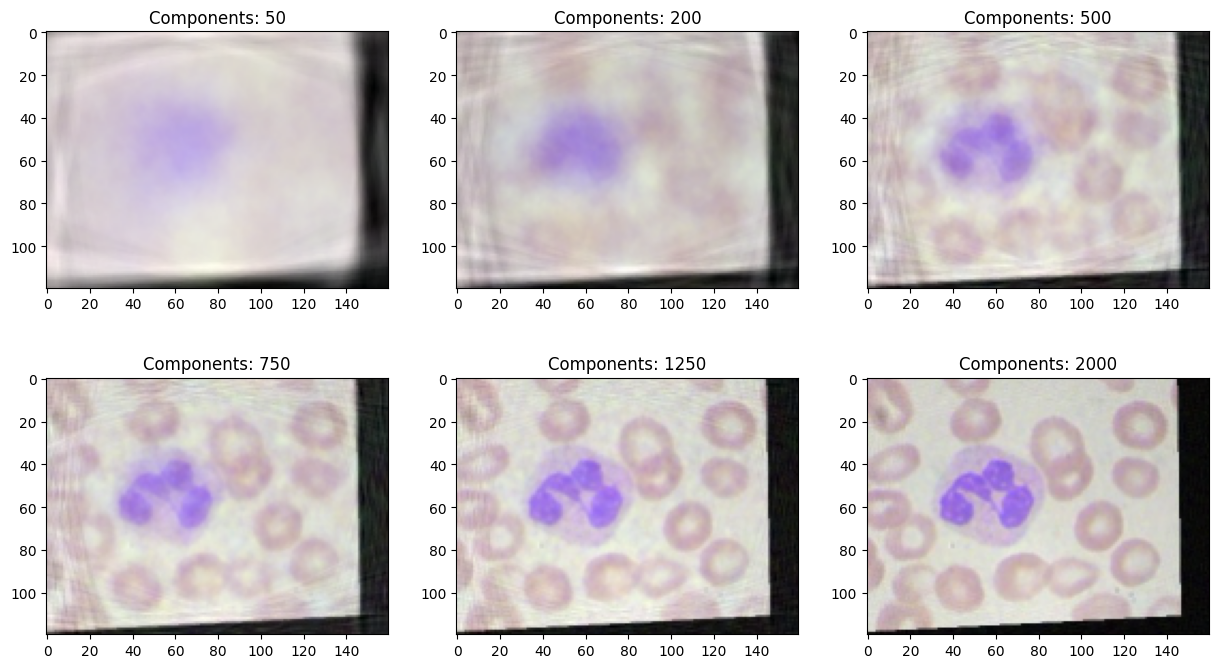

In [24]:
def plot_at_k(k):
    pca = PCA(n_components=k)
    x = df_first_2500.iloc[:, :-1]
    x = x.astype(float) / 255
    x = pca.fit_transform(x)
    dff = pd.DataFrame(pca.inverse_transform(x))
    image = np.array(dff.iloc[3, :]).reshape((120, 160, 3))
    image = (image - np.min(image)) / (np.max(image) - np.min(image))  # Scale values between 0 and 1
    image = (image * 255).astype(np.uint8)  # Scale values between 0 and 255
    plt.imshow(image)

    
ks = [50, 200, 500, 750, 1250, 2000]
df_first_2500 = df_train.head(2500)
plt.figure(figsize=[15, 9])

for i in range(6):
    plt.subplot(2, 3, i+1)
    plot_at_k(ks[i])
    plt.title("Components: " + str(ks[i]))

plt.subplots_adjust(wspace=0.2, hspace=0.0)
plt.show()

In [13]:
pca = PCA(n_components=2000)
df_train_reconstructed_pca = pca.inverse_transform(pca.fit_transform(df_train.iloc[:, :-1]))
df_test_reconstructed_pca = pca.inverse_transform(pca.transform(df_test.iloc[:, :-1]))

In [14]:
def scale_again_to_0_255(df):
    min_value = df.min().min()
    max_value = df.max().max()
    scaled_df = (df - min_value) * (255 / (max_value - min_value))

    # Convert the scaled DataFrame to uint8
    return scaled_df.astype(np.uint8)

In [15]:
df_train_reconstructed_pca = pd.DataFrame(df_train_reconstructed_pca)
df_test_reconstructed_pca = pd.DataFrame(df_test_reconstructed_pca)

In [16]:
df_train_reconstructed_pca = scale_again_to_0_255(df_train_reconstructed_pca)
df_test_reconstructed_pca = scale_again_to_0_255(df_test_reconstructed_pca)

In [17]:
df_train_reconstructed_pca['label'] = df_train.iloc[:, -1]
df_test_reconstructed_pca['label'] = df_test.iloc[:, -1]

In [18]:
df_train_reconstructed_pca.to_csv('train_pca.csv', index=False)
df_test_reconstructed_pca.to_csv('test_pca.csv', index=False)

### Color reduction - KMeans

In [3]:
df_train_reconstructed_pca = pd.read_csv('train_pca.csv')
df_test_reconstructed_pca = pd.read_csv('test_pca.csv')

In [22]:
df_train_reconstructed_pca = df_train_reconstructed_pca.iloc[:, :-1]
df_test_reconstructed_pca = df_test_reconstructed_pca.iloc[:, :-1]

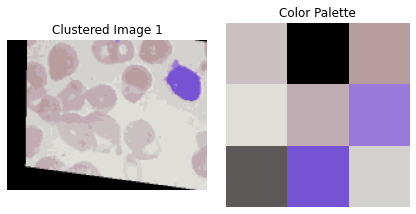

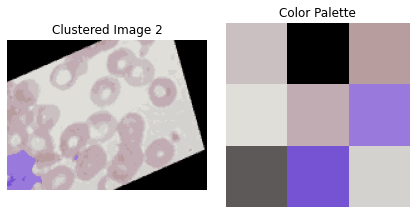

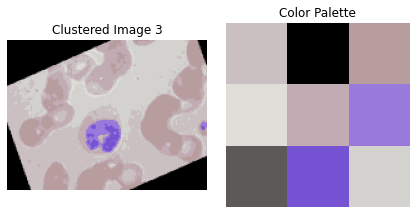

In [19]:
image_paths = [os.path.join(lymp_path, random.choice(os.listdir(lymp_path))),
               os.path.join(mono_path, random.choice(os.listdir(mono_path))),
               os.path.join(mono_path, random.choice(os.listdir(mono_path)))]
preprocessed_images = []
for path in image_paths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    resized_image = cv2.resize(image, (160, 120))  # Resize if needed
    flattened_image = resized_image.reshape(-1, 3)  # Flatten the image to a feature vector
    preprocessed_images.append(flattened_image)

# Step 2: Combine the feature vectors
combined_data = np.concatenate(preprocessed_images, axis=0)

# Step 3: Apply k-means clustering
kmeans = KMeans(n_clusters=9, random_state=42,n_init=10)
kmeans.fit(combined_data)

# Step 4: Obtain cluster centroids and colors
centroids = kmeans.cluster_centers_
cluster_colors = centroids.astype(np.uint8)

# Step 5: Assign colors to images and plot color palette
for i, path in enumerate(image_paths):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    resized_image = cv2.resize(image, (160, 120))  # Resize if needed
    flattened_image = resized_image.reshape(-1, 3)  # Flatten the image to a feature vector
    
    # Assign nearest centroid color to each pixel
    labels = kmeans.predict(flattened_image)
    assigned_colors = cluster_colors[labels]
    clustered_image = assigned_colors.reshape(resized_image.shape)

    # Plot the clustered image and color palette
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    ax1.imshow(clustered_image)
    ax1.axis('off')
    ax1.set_title(f"Clustered Image {i+1}")

    color_palette = cluster_colors.reshape((3, 3, 3))
    ax2.imshow(color_palette)
    ax2.axis('off')
    ax2.set_title("Color Palette")

    plt.tight_layout()
    plt.show()

In [20]:
def reduce_colors(x_train,x_test):
    x_train = x_train.values.reshape(-1, 19200, 3)
    x_train =  x_train.tolist()
    x_test = x_test.values.reshape(-1, 19200, 3)
    x_test =  x_test.tolist()
    random_samples = random.sample(x_train, k=20)
    combined_data = np.concatenate(random_samples, axis=0)
    # Apply k-means clustering
    kmeans = KMeans(n_clusters=9, random_state=42, n_init=10)
    kmeans.fit(combined_data)

    # Obtain cluster centroids
    centroids = kmeans.cluster_centers_
    centroids_uint8 = centroids.astype(np.uint8)  # Convert centroids to uint8

    train = []
    test = []
    # Assign colors to images
    for flattened_image in x_train:
        # Assign nearest centroid color to each pixel
        labels = kmeans.predict(flattened_image)
        train.append(centroids_uint8[labels])
    for flattened_image in x_test:
        labels = kmeans.predict(flattened_image)
        test.append(centroids_uint8[labels])
    return train, test

In [ ]:
df_train_reduced_pca, df_test_reduced_pca = reduce_colors(df_train_reconstructed_pca,df_test_reconstructed_pca)

In [20]:
df_train.to_csv('train_reduce.csv', index=False)
df_test.to_csv('test_reduce.csv', index=False)

### Max Pooling

In [28]:
def max_pooling(df):
    pooled_images = []  # List to store pooled images
    for i in range(len(df)):
        img = df.values[i].reshape(120, 160, 3)
        max_pool = block_reduce(img, block_size=(5, 5, 1), func=np.max)
        ravel_img = max_pool.ravel()
        pooled_images.append(ravel_img)

    # Create DataFrame from the pooled images list
    max_pool_df = pd.DataFrame(pooled_images)
    return max_pool_df

In [29]:
df_train_max_pool = max_pooling(pd.DataFrame(df_train_reconstructed_pca))
df_test_max_pool = max_pooling(pd.DataFrame(df_test_reconstructed_pca))

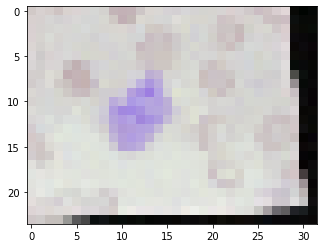

In [33]:
img = df_train_max_pool.iloc[5, :] / 255
plt.imshow(np.array(img).reshape(24, 32, 3))

In [34]:
df_train_max_pool = df_train_max_pool.join(df_train.iloc[:, -1])
df_test_max_pool = df_test_max_pool.join(df_test.iloc[:, -1])

In [35]:
df_train_max_pool.to_csv('C:/Users/נעמיה/OneDrive - Ariel University/ML project/train_pca_maxpool.csv', index=False)
df_test_max_pool.to_csv('C:/Users/נעמיה/OneDrive - Ariel University/ML project/test_pca_maxpool.csv', index=False)

In [3]:
df_train_max_pool = pd.read_csv('C:/Users/נעמיה/OneDrive - Ariel University/ML project/train_pca_mpool.csv')
df_test_max_pool = pd.read_csv('C:/Users/נעמיה/OneDrive - Ariel University/ML project/test_pca_mpool.csv')

# Models


In [21]:
def plot_confusion_matrix(model, X_train, y_train, X_test, y_test):
    labels = ["Monocyte", "Lymphocyte", "Neutrophil", "Eosinophil"]
    model.fit(X_train, y_train)
    
    # Model prediction
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    print("Training Accuracy:", model.score(X_train, y_train))
    print("Testing Accuracy:", accuracy)
    print()
    print(classification_report(y_test, y_pred, labels=range(1,len(labels)+1), target_names=labels))
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot the confusion matrix using seaborn heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, ax=ax, linewidths=1)
    
    # Set labels, title, and ticks
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    
    # Set x-axis and y-axis tick labels
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    # Show the plot
    plt.show()

In [5]:
X_train, y_train = df_train_max_pool.iloc[:, :-1], df_train_max_pool.iloc[:, -1]
X_test, y_test = df_test_max_pool.iloc[:, :-1], df_test_max_pool.iloc[:, -1]

### Scaling

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### KNN

In [7]:
k_range = list(range(1, 20, 1))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Testing Accuracy')

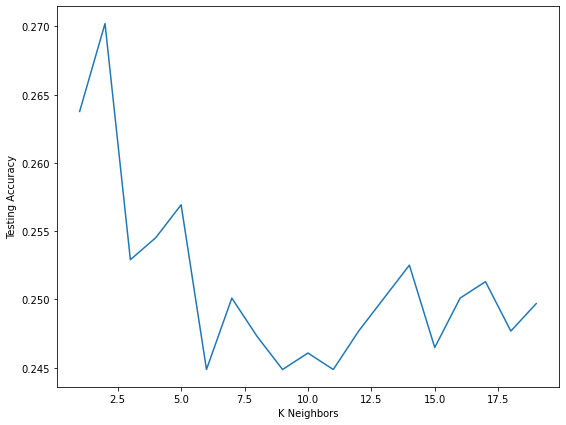

In [8]:
plt.subplots(figsize=(9, 7))
plt.plot(k_range, scores)
plt.xlabel('K Neighbors')
plt.ylabel('Testing Accuracy')

Training Accuracy: 1.0
Testing Accuracy: 0.2637716123843989

              precision    recall  f1-score   support

    Monocyte       0.25      0.20      0.22       620
  Lymphocyte       0.40      0.15      0.22       620
  Neutrophil       0.23      0.48      0.32       624
  Eosinophil       0.29      0.23      0.26       623

    accuracy                           0.26      2487
   macro avg       0.29      0.26      0.25      2487
weighted avg       0.29      0.26      0.25      2487



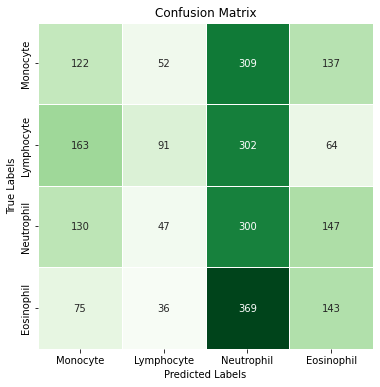

In [9]:
plot_confusion_matrix(KNeighborsClassifier(n_neighbors=1), X_train, y_train, X_test, y_test)

**The accuracy result of KNN is almost no better than a dummy model predicted by randomness.**

KNN is generally not well-suited for classifying images, especially in cases where the images have complex variations and noise (as our case). Here are some reasons why KNN may struggle to succeed in image classification:

1. High-dimensional feature space: Images are represented by high-dimensional feature vectors, with each dimension corresponding to a pixel or a set of features. In high-dimensional spaces, the notion of distance becomes less meaningful, and the curse of dimensionality can lead to sparsity and increased computational complexity. This makes it challenging for KNN to accurately measure the similarity between images based on their feature vectors.

2. Sensitivity to irrelevant features: Images often contain a large number of irrelevant or noisy features that can hinder classification accuracy. KNN treats all features equally, which means it considers both relevant and irrelevant features during classification. This sensitivity to irrelevant features can lead to inaccurate results, especially when the noise or irrelevant features dominate the classification decision.

3. Lack of spatial information: KNN does not consider the spatial relationships and structural information present in images. It treats each pixel or feature independently without considering the arrangement or context of neighboring pixels. This can make it difficult for KNN to capture the meaningful spatial dependencies and patterns necessary for accurate image classification.

### Logistic Regression

Training Accuracy: 0.7283318268554786
Testing Accuracy: 0.3988741455568959

              precision    recall  f1-score   support

    Monocyte       0.55      0.60      0.57       620
  Lymphocyte       0.44      0.33      0.38       620
  Neutrophil       0.31      0.36      0.33       624
  Eosinophil       0.32      0.32      0.32       623

    accuracy                           0.40      2487
   macro avg       0.40      0.40      0.40      2487
weighted avg       0.40      0.40      0.40      2487



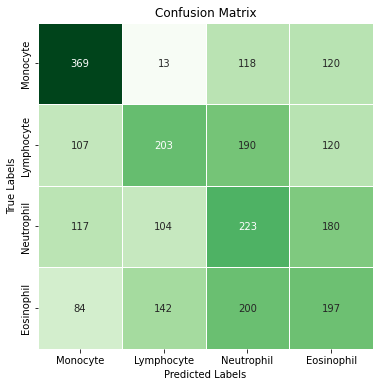

In [10]:
plot_confusion_matrix(LogisticRegression(solver='liblinear'), X_train, y_train, X_test, y_test)

Training Accuracy: 0.7446017876870543
Testing Accuracy: 0.3956574185765983

              precision    recall  f1-score   support

    Monocyte       0.53      0.57      0.55       620
  Lymphocyte       0.44      0.32      0.37       620
  Neutrophil       0.31      0.38      0.34       624
  Eosinophil       0.32      0.31      0.31       623

    accuracy                           0.40      2487
   macro avg       0.40      0.40      0.39      2487
weighted avg       0.40      0.40      0.39      2487



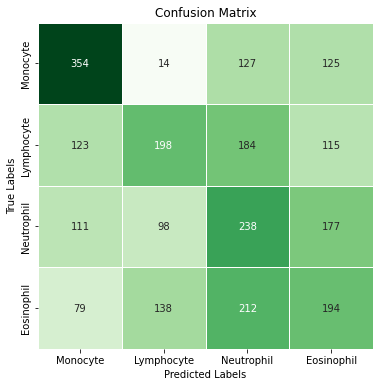

In [11]:
plot_confusion_matrix(LogisticRegression(solver='lbfgs',max_iter=4000), X_train, y_train, X_test, y_test)

We added iterations to allow convergence of the model.

### SVM

Training Accuracy: 0.8501556693783268
Testing Accuracy: 0.3220747889022919

              precision    recall  f1-score   support

    Monocyte       0.76      0.14      0.24       620
  Lymphocyte       0.71      0.23      0.35       620
  Neutrophil       0.27      0.66      0.38       624
  Eosinophil       0.26      0.26      0.26       623

    accuracy                           0.32      2487
   macro avg       0.50      0.32      0.31      2487
weighted avg       0.50      0.32      0.31      2487



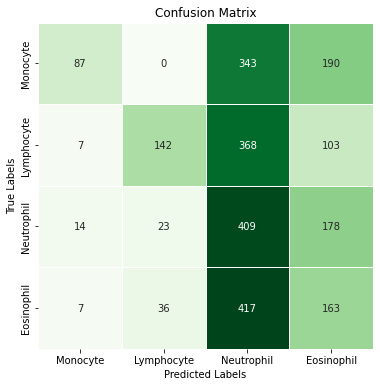

In [12]:
plot_confusion_matrix(SVC(C=0.5,kernel='poly'), X_train, y_train, X_test, y_test)

Training Accuracy: 0.6440694988450336
Testing Accuracy: 0.4338560514676317

              precision    recall  f1-score   support

    Monocyte       0.70      0.58      0.63       620
  Lymphocyte       0.52      0.38      0.44       620
  Neutrophil       0.35      0.48      0.40       624
  Eosinophil       0.28      0.30      0.29       623

    accuracy                           0.43      2487
   macro avg       0.46      0.43      0.44      2487
weighted avg       0.46      0.43      0.44      2487



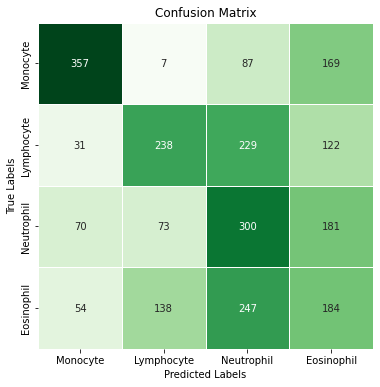

In [13]:
plot_confusion_matrix(SVC(C=0.25,kernel='rbf'), X_train, y_train, X_test, y_test)

Training Accuracy: 0.7921060560409762
Testing Accuracy: 0.44189786891837557

              precision    recall  f1-score   support

    Monocyte       0.72      0.55      0.63       620
  Lymphocyte       0.58      0.42      0.48       620
  Neutrophil       0.33      0.51      0.40       624
  Eosinophil       0.29      0.29      0.29       623

    accuracy                           0.44      2487
   macro avg       0.48      0.44      0.45      2487
weighted avg       0.48      0.44      0.45      2487



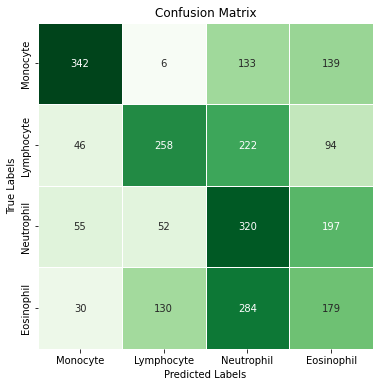

In [14]:
plot_confusion_matrix(SVC(C=0.5,kernel='rbf'), X_train, y_train, X_test, y_test)

Training Accuracy: 0.9129255799939741
Testing Accuracy: 0.43104141535987134

              precision    recall  f1-score   support

    Monocyte       0.75      0.49      0.59       620
  Lymphocyte       0.60      0.43      0.50       620
  Neutrophil       0.33      0.54      0.41       624
  Eosinophil       0.27      0.27      0.27       623

    accuracy                           0.43      2487
   macro avg       0.49      0.43      0.44      2487
weighted avg       0.49      0.43      0.44      2487



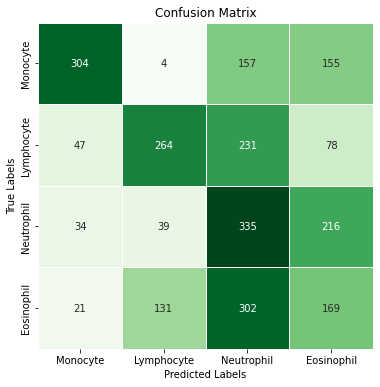

In [15]:
plot_confusion_matrix(SVC(C=1,kernel='rbf'), X_train, y_train, X_test, y_test)

Training Accuracy: 1.0
Testing Accuracy: 0.4189786891837555

              precision    recall  f1-score   support

    Monocyte       0.71      0.45      0.55       620
  Lymphocyte       0.59      0.39      0.47       620
  Neutrophil       0.32      0.54      0.40       624
  Eosinophil       0.29      0.30      0.30       623

    accuracy                           0.42      2487
   macro avg       0.48      0.42      0.43      2487
weighted avg       0.48      0.42      0.43      2487



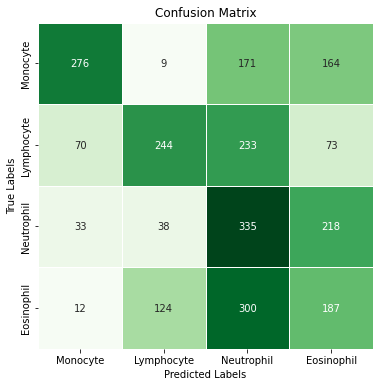

In [16]:
plot_confusion_matrix(SVC(C=10,kernel='rbf'), X_train, y_train, X_test, y_test)

### Decision Tree and Random Forest

Training Accuracy: 1.0
Testing Accuracy: 0.3333333333333333

              precision    recall  f1-score   support

    Monocyte       0.41      0.36      0.38       620
  Lymphocyte       0.38      0.32      0.35       620
  Neutrophil       0.29      0.35      0.32       624
  Eosinophil       0.29      0.30      0.29       623

    accuracy                           0.33      2487
   macro avg       0.34      0.33      0.33      2487
weighted avg       0.34      0.33      0.33      2487



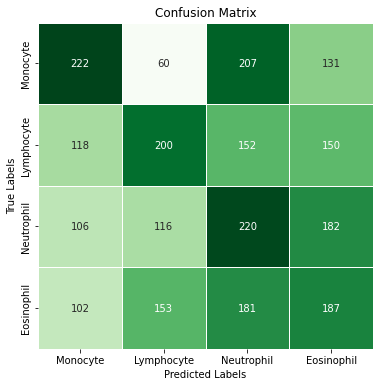

In [17]:
plot_confusion_matrix(DecisionTreeClassifier(random_state=0), X_train, y_train, X_test, y_test)

Training Accuracy: 1.0
Testing Accuracy: 0.44310414153598715

              precision    recall  f1-score   support

    Monocyte       0.73      0.56      0.64       620
  Lymphocyte       0.48      0.39      0.43       620
  Neutrophil       0.35      0.50      0.41       624
  Eosinophil       0.32      0.31      0.32       623

    accuracy                           0.44      2487
   macro avg       0.47      0.44      0.45      2487
weighted avg       0.47      0.44      0.45      2487



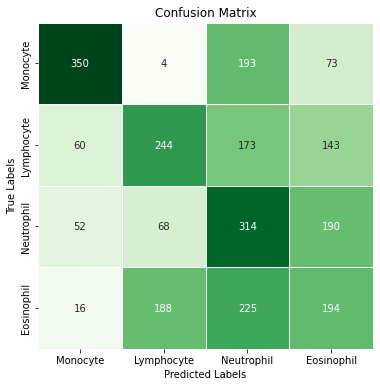

In [18]:
plot_confusion_matrix(RandomForestClassifier(random_state=0), X_train , y_train , X_test, y_test)

### Voting

Training Accuracy: 0.9146329215627197
Testing Accuracy: 0.4571773220747889

              precision    recall  f1-score   support

    Monocyte       0.65      0.66      0.65       620
  Lymphocyte       0.52      0.43      0.47       620
  Neutrophil       0.35      0.46      0.40       624
  Eosinophil       0.33      0.28      0.30       623

    accuracy                           0.46      2487
   macro avg       0.46      0.46      0.46      2487
weighted avg       0.46      0.46      0.46      2487



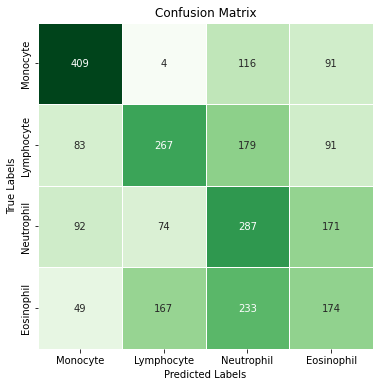

In [19]:
clf1 = LogisticRegression(solver='liblinear')
clf2 = RandomForestClassifier(random_state=0)
clf3 = SVC(C=0.5,kernel='rbf')
vot = VotingClassifier(estimators=[ ('lr', clf1), ('rf', clf2), ('svm', clf3)], voting='hard')
plot_confusion_matrix(vot, X_train, y_train, X_test, y_test)

### Neural Network - CNN

In [33]:
X_train_s, y_train_s = df_train.iloc[:, :-1], df_train.iloc[:, -1]
X_test_s, y_test_s = df_test.iloc[:, :-1], df_test.iloc[:, -1]
X_test_s, X_val, y_test_s, y_val = train_test_split(X_test_s, y_test_s, test_size = 0.5)

In [36]:
reshaped_X_train = X_train_s.to_numpy().reshape((9957, 120, 160, 3))
reshaped_X_test = X_test_s.to_numpy().reshape((1243, 120, 160, 3))
reshaped_X_val = X_val.to_numpy().reshape((1244, 120, 160, 3))

In [38]:
reshaped_X_train_s = reshaped_X_train_s / 255.0 
reshaped_X_val = reshaped_X_val / 255.0
reshaped_X_test_s = reshaped_X_test_s / 255.0

In [56]:
model1 = Sequential()

# First Conv Layer
model1.add(Conv2D(16 , (3,3) , activation = 'relu' , input_shape = (120,160,3)))
model1.add(MaxPooling2D(pool_size = (2,2)))

# Second Conv Layer
model1.add(Conv2D(32, (3,3), activation = 'relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.25))

# Third Conv Layer
model1.add(Conv2D(64, (3,3), activation = 'relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.25))

# FC layer
model1.add(Flatten())
model1.add(Dense(units = 128 , activation = 'relu'))
model1.add(Dropout(0.25))

# Output layer
model1.add(Dense(units = 4 , activation = 'softmax'))

# Compile
model1.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model1.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
# Train
history1 = model1.fit(
    reshaped_X_train_s, 
    y_train_s, 
    batch_size = 32, 
    epochs = 50, 
    validation_data=(reshaped_X_val, y_val),
    callbacks=[early_stopping]
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 118, 158, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 59, 79, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 57, 77, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 28, 38, 32)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 28, 38, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 26, 36, 64)       

In [64]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(1,len(history.history['accuracy'])+1)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'b-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

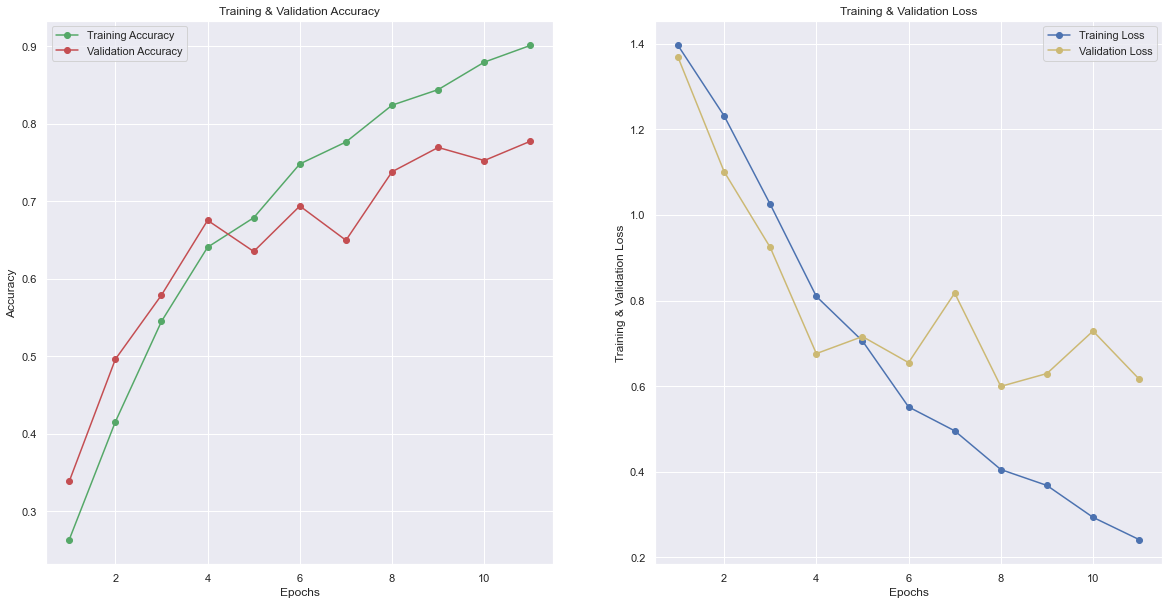

In [65]:
plot_accuracy_loss_chart(history1)


In [61]:
results = model1.evaluate(reshaped_X_test_s, y_test_s)

print("Loss of the model  is - test ", results[0])
print("Accuracy of the model is - test", results[1]*100, "%")

39/39 [==============================] - 4s 110ms/step - loss: 0.5940 - accuracy: 0.7836
Loss of the model  is - test  0.5940081477165222
Accuracy of the model is - test 78.35881114006042 %


### Unprocessed RGB images

We wanted to check what happens if we do not perform PCA and Max pooling. Does the information lost in these tools detract from the performance of the models? It turns out not. 

Here is the Random Forest model (which produced the best performance for the processed data). 
It can be seen that it brings a lower accuracy:

Training Accuracy: 1.0
Testing Accuracy: 0.3916365098512264

              precision    recall  f1-score   support

    Monocyte       0.57      0.45      0.50       620
  Lymphocyte       0.47      0.38      0.42       620
  Neutrophil       0.37      0.46      0.41       624
  Eosinophil       0.24      0.27      0.25       623

    accuracy                           0.39      2487
   macro avg       0.41      0.39      0.40      2487
weighted avg       0.41      0.39      0.40      2487



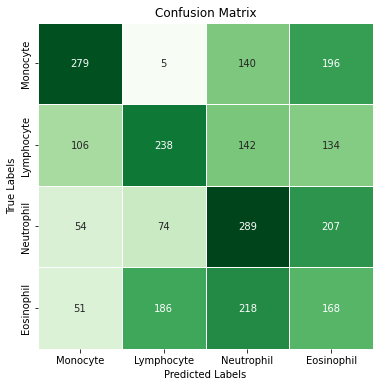

In [25]:
plot_confusion_matrix(RandomForestClassifier(random_state=0), df_train.iloc[:, :-1] , df_train.iloc[:, -1] , df_test.iloc[:, :-1], df_test.iloc[:, -1])

## Grayscale images

In [28]:
xtr_g, ytr_g = load_dataset(train_dir,'GRAY')
xte_g, yte_g = load_dataset(test_dir,'GRAY')
train_g = pd.DataFrame(np.array(xtr_g).reshape(-1, 19200))
test_g = pd.DataFrame(np.array(xte_g).reshape(-1, 19200))
train_g['label'] = ytr_g
test_g['label'] = yte_g
train_g = shuffle(train_g).reset_index(drop=True)
test_g = shuffle(test_g).reset_index(drop=True)

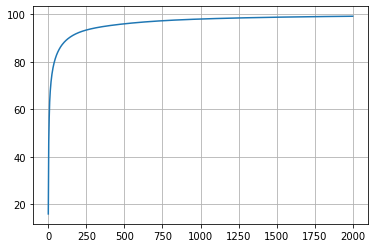

In [29]:
pcag = PCA(n_components=2000)
pcag.fit(train_g)
plt.grid()
plt.plot(np.cumsum(pcag.explained_variance_ratio_*100))
plt.savefig('pcag.png')

In [30]:
pcag = PCA(n_components=1800)
train_g_reconstructed_pca = pd.DataFrame(pcag.inverse_transform(pcag.fit_transform(train_g.iloc[:, :-1])))
test_g_reconstructed_pca =  pd.DataFrame(pcag.inverse_transform(pcag.transform(test_g.iloc[:, :-1])))

In [31]:
train_g_reconstructed_pca

,0,1,2,3,4,5,6,7,8,9,...,19190,19191,19192,19193,19194,19195,19196,19197,19198,19199
0,4.139806,-3.845421,-5.107707,2.865605,1.962058,-0.078477,4.571151,0.353279,3.795966,17.105278,...,200.941385,200.901846,201.878455,206.093612,208.170919,206.619152,204.223540,210.208875,206.596706,206.001327
1,9.871547,-8.219905,-11.308679,3.101669,-8.534469,-1.551754,11.877987,1.131959,13.308834,162.936817,...,-0.218161,-2.208868,4.193420,13.954958,5.345021,5.699432,2.621997,-1.260979,-0.178477,-6.106312
2,4.268705,-2.498196,-2.858487,0.765888,3.209048,4.151114,1.496555,-1.700261,4.283618,4.687100,...,-5.776482,-2.233567,-5.846741,-1.600585,2.191104,3.612686,0.487004,3.896167,0.881544,3.153499
3,12.790905,2.186900,0.647294,4.852123,3.875186,3.709627,3.037919,-3.258962,-2.814905,1.059298,...,3.594059,3.707430,-2.755582,-0.613204,1.296358,0.321827,-0.475940,-6.978795,-3.493529,0.722264
4,11.020108,-1.169655,-2.111632,9.032563,0.074219,-3.147397,-2.676975,1.202289,-4.643235,5.430969,...,-1.308390,-5.441497,0.207709,-1.715564,5.216023,10.583564,3.159151,-2.196932,0.758118,-0.429165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9952,-5.131608,-12.718524,-0.484342,0.947304,-2.460535,-2.403880,1.677349,51.978556,162.746140,200.910549,...,184.196547,206.563750,221.842769,228.627369,220.928855,213.268991,197.727826,195.259700,188.158950,184.227601
9953,0.626812,-4.781397,3.628742,-3.408993,6.440128,-2.181527,-5.001735,0.410463,2.622823,-0.054424,...,5.153028,5.711098,1.169434,-0.226320,0.652062,-2.480489,-6.807612,-6.587173,-4.538323,-10.456166
9954,172.493100,174.221154,174.835224,190.009362,196.287856,198.862417,198.034812,200.519246,200.407780,202.050998,...,-4.558533,0.169913,-9.619628,0.757742,-0.668886,4.531827,2.938000,4.095194,6.901968,1.386786
9955,3.375419,-1.243074,5.411092,-1.500892,-11.711219,-6.322390,-3.809536,-0.072504,2.591705,-0.588629,...,1.612982,3.682113,-2.387670,-5.895804,1.044821,-1.983054,-5.368014,2.464586,-3.486924,2.137085


In [32]:
def max_pooling_g(df):
    pooled_images = []  # List to store pooled images
    for i in range(len(df)):
        img = df.values[i].reshape(120, 160)
        max_pool = block_reduce(img, block_size=(4, 4), func=np.max)
        ravel_img = max_pool.ravel()
        pooled_images.append(ravel_img)

    # Create DataFrame from the pooled images list
    max_pool_df = pd.DataFrame(pooled_images)
    return max_pool_df
train_g_reconstructed_pca = max_pooling_g(train_g_reconstructed_pca)
test_g_reconstructed_pca = max_pooling_g(test_g_reconstructed_pca)

In [33]:
train_g_reconstructed_pca

,0,1,2,3,4,5,6,7,8,9,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,6.477396,9.653015,175.525499,188.851091,184.320136,184.109468,185.302313,180.378991,183.763780,193.407680,...,220.045080,219.856417,213.561339,215.557106,218.592894,216.139696,214.040086,219.593022,214.941340,213.354712
1,10.245366,14.244001,213.734419,202.355236,203.075157,207.470205,201.965706,191.292593,206.733458,201.567900,...,9.377743,9.666786,9.459709,8.245242,16.562687,10.683648,14.194019,27.241063,89.489162,109.170954
2,5.162365,4.151114,4.687100,4.066629,4.881965,6.168128,7.831024,5.197697,5.637180,5.334065,...,5.158260,4.343081,4.575034,4.633708,10.363951,5.345789,5.818619,6.517880,5.407919,6.090121
3,12.790905,3.875186,5.989973,7.075084,4.420575,7.494732,8.096512,1.975779,5.301438,4.150603,...,4.739603,7.467174,4.514804,1.448254,6.536105,6.425677,5.346702,4.186768,3.696107,3.529527
4,11.020108,2.430112,9.820792,10.843549,6.191297,8.287930,5.728496,6.121224,6.565394,4.380719,...,8.177743,9.297315,3.248293,8.190703,7.575369,6.325535,6.993759,8.371460,10.583564,4.901034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9952,10.570732,99.457024,213.040951,210.856425,211.064058,210.556786,185.692679,183.493019,201.404909,214.181427,...,210.834547,225.549415,208.445883,183.408858,184.515626,183.344306,180.385473,206.563750,228.627369,208.319753
9953,3.628742,8.924845,10.769152,8.571424,184.310250,178.780064,175.714608,196.544097,219.722577,212.659133,...,15.399974,5.544940,4.804725,6.957946,9.094549,9.446010,7.113902,24.735985,29.788202,33.561675
9954,190.009362,200.519246,205.186800,192.944371,209.018051,229.144425,223.026369,210.229743,226.084714,227.728783,...,208.296476,185.477367,184.013843,185.924923,203.655705,216.375208,222.434374,12.193242,4.820429,6.901968
9955,7.336565,7.115831,3.756175,9.472047,6.711503,7.662372,7.470419,8.709542,1.158075,4.534283,...,4.540091,6.285107,3.160838,9.462382,4.419561,7.771368,5.181711,3.682113,6.033421,5.118462


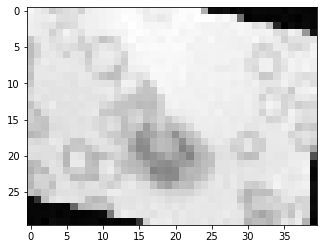

In [34]:
img = train_g_reconstructed_pca.iloc[6, :]
plt.imshow(np.array(img).reshape(30, 40),cmap='gray')

In [37]:
scaler = StandardScaler()
X_train_g = scaler.fit_transform(train_g_reconstructed_pca)
X_test_g = scaler.transform(test_g_reconstructed_pca)

In [38]:
k_range = list(range(1, 20, 1))
scoresg = []
for k in k_range:
    knng = KNeighborsClassifier(n_neighbors=k)
    knng.fit(X_train_g, train_g.iloc[:, -1])
    y_pred = knng.predict(X_test_g)
    scoresg.append(accuracy_score(test_g.iloc[:, -1], y_pred))

Text(0, 0.5, 'Testing Accuracy')

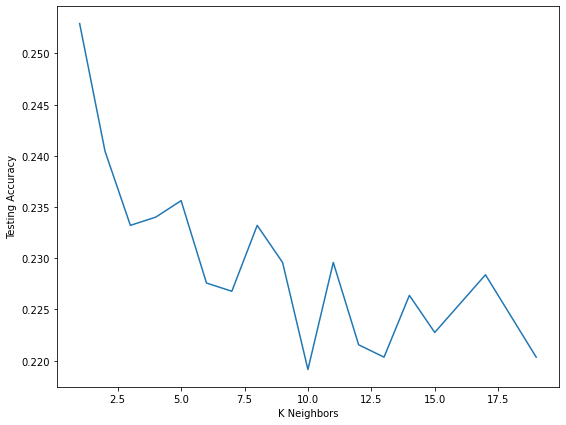

In [41]:
plt.subplots(figsize=(9, 7))
plt.plot(k_range, scoresg)
plt.xlabel('K Neighbors')
plt.ylabel('Testing Accuracy')

Training Accuracy: 1.0
Testing Accuracy: 0.25291515882589466

              precision    recall  f1-score   support

    Monocyte       0.22      0.19      0.21       620
  Lymphocyte       0.41      0.16      0.23       620
  Neutrophil       0.23      0.41      0.29       624
  Eosinophil       0.26      0.25      0.25       623

    accuracy                           0.25      2487
   macro avg       0.28      0.25      0.25      2487
weighted avg       0.28      0.25      0.25      2487



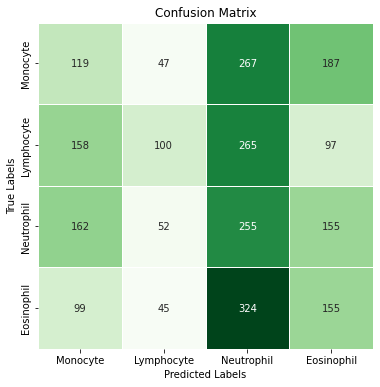

In [42]:
plot_confusion_matrix(KNeighborsClassifier(n_neighbors=1), X_train_g, train_g.iloc[:, -1], X_test_g, test_g.iloc[:, -1])

Training Accuracy: 0.5055739680626695
Testing Accuracy: 0.26537997587454765

              precision    recall  f1-score   support

    Monocyte       0.28      0.27      0.28       620
  Lymphocyte       0.30      0.31      0.31       620
  Neutrophil       0.24      0.26      0.25       624
  Eosinophil       0.23      0.22      0.23       623

    accuracy                           0.27      2487
   macro avg       0.27      0.27      0.27      2487
weighted avg       0.27      0.27      0.27      2487



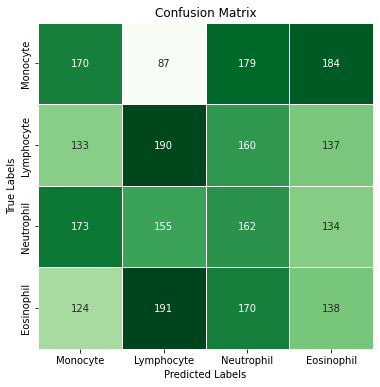

In [43]:
plot_confusion_matrix(LogisticRegression(solver='liblinear'), X_train_g, train_g.iloc[:, -1], X_test_g, test_g.iloc[:, -1])

Training Accuracy: 0.504268353921864
Testing Accuracy: 0.26457579412947324

              precision    recall  f1-score   support

    Monocyte       0.28      0.27      0.28       620
  Lymphocyte       0.30      0.31      0.30       620
  Neutrophil       0.24      0.26      0.25       624
  Eosinophil       0.24      0.22      0.23       623

    accuracy                           0.26      2487
   macro avg       0.27      0.26      0.26      2487
weighted avg       0.26      0.26      0.26      2487



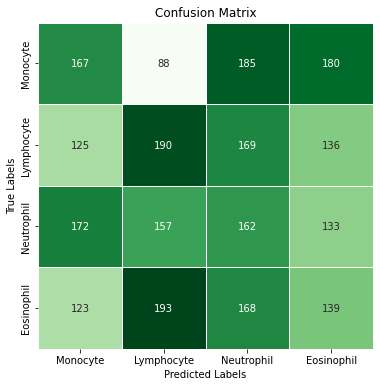

In [44]:
plot_confusion_matrix(LogisticRegression(solver='lbfgs',max_iter=4000), X_train_g, train_g.iloc[:, -1], X_test_g, test_g.iloc[:, -1])

Training Accuracy: 1.0
Testing Accuracy: 0.27141133896260555

              precision    recall  f1-score   support

    Monocyte       0.24      0.18      0.20       620
  Lymphocyte       0.37      0.33      0.35       620
  Neutrophil       0.26      0.33      0.29       624
  Eosinophil       0.23      0.25      0.24       623

    accuracy                           0.27      2487
   macro avg       0.27      0.27      0.27      2487
weighted avg       0.27      0.27      0.27      2487



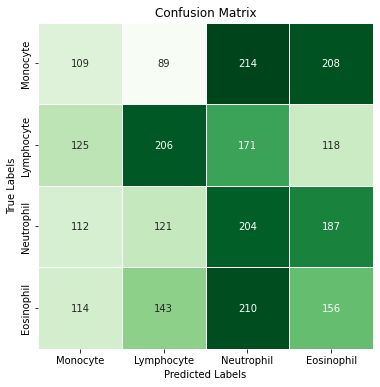

In [45]:
plot_confusion_matrix(DecisionTreeClassifier(random_state=0), X_train_g, train_g.iloc[:, -1], X_test_g, test_g.iloc[:, -1])

Training Accuracy: 1.0
Testing Accuracy: 0.3108162444712505

              precision    recall  f1-score   support

    Monocyte       0.31      0.19      0.24       620
  Lymphocyte       0.47      0.41      0.44       620
  Neutrophil       0.33      0.41      0.36       624
  Eosinophil       0.19      0.23      0.21       623

    accuracy                           0.31      2487
   macro avg       0.32      0.31      0.31      2487
weighted avg       0.32      0.31      0.31      2487



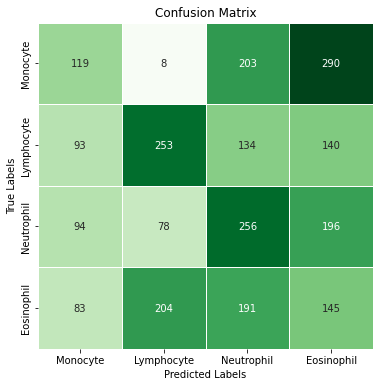

In [46]:
plot_confusion_matrix(RandomForestClassifier(random_state=0), X_train_g, train_g.iloc[:, -1], X_test_g, test_g.iloc[:, -1])

Training Accuracy: 0.692979813196746
Testing Accuracy: 0.28990751909931645

              precision    recall  f1-score   support

    Monocyte       0.27      0.15      0.20       620
  Lymphocyte       0.55      0.35      0.43       620
  Neutrophil       0.27      0.40      0.32       624
  Eosinophil       0.19      0.26      0.22       623

    accuracy                           0.29      2487
   macro avg       0.32      0.29      0.29      2487
weighted avg       0.32      0.29      0.29      2487



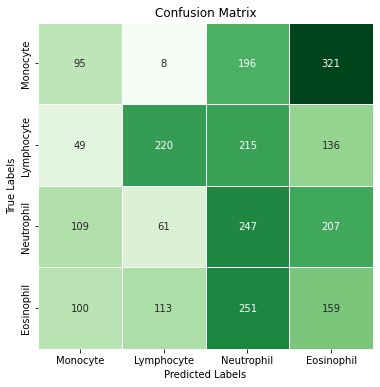

In [47]:
plot_confusion_matrix(SVC(C=0.5,kernel='rbf'), X_train_g, train_g.iloc[:, -1], X_test_g, test_g.iloc[:, -1])